In [1]:
import numpy as np
import pandas as pd
import re
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import Binarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
rela1 = Path("ODI-2019-csv.csv")
abso1 = rela1.absolute()
ODI_raw = pd.read_csv(abso1, sep=';')
ODI_pro = pd.read_csv("ODI_pro.csv")

In [3]:
ODI = ODI_raw.filter(['What is your gender?',
                    'Have you taken a course on machine learning?',
                    'Have you taken a course on information retrieval?', 
                    'Have you taken a course on statistics?', 
                    'Have you taken a course on databases?',
                    'You can get 100 euros if you win a local DM competition, or we don’t hold any competitions \
                    and I give everyone some money (not the same amount!). How much do you think \
                    you would deserve then?',
                    'Number of neighbors sitting around you?',
                    'What is your stress level (0-100)?']).copy()
ODI['100 ranking'] = ODI_raw.iloc[:,11].copy()
ODI = ODI.rename(columns = 
                 {'What is your gender?':'gender',
                 'Have you taken a course on machine learning?':'machine learning',
                 'Have you taken a course on information retrieval?':'information retrieval',
                 'Have you taken a course on statistics?':'statistics',
                 'Have you taken a course on databases?':'databases', 
                'Number of neighbors sitting around you?':'neighbors',
                 'What is your stress level (0-100)?':'stress level'})

In [4]:
ODI = ODI[['gender','machine learning','information retrieval','statistics','databases','neighbors',
          '100 ranking','stress level']]

In [5]:
ODI = pd.merge(ODI_pro, ODI, left_index = True, right_index = True, how='outer')

In [6]:
ODI['gender'] = ODI['gender'].str.replace('female', 'F')
ODI['gender'] = ODI['gender'].str.replace('male', 'M')
F = ODI['gender'].str.contains('F')
N = ODI['gender'].str.contains('unknown')
M = ODI['gender'].str.contains('M')
ODI['gender'] = np.where(F, int('1'),
                        np.where(N, float('NaN'),
                            np.where(M, int('0'),
                                    ODI['gender'].str.replace('-', ' '))))
T = ODI['machine learning'].str.contains('yes')
N = ODI['machine learning'].str.contains('unknown')
F = ODI['machine learning'].str.contains('no')
ODI['machine learning'] = np.where(T, int('1'),
                        np.where(N, float('NaN'),
                            np.where(F, int('0'),
                                    ODI['machine learning'].str.replace('-', ' '))))

T = ODI['information retrieval'].str.contains('1')
N = ODI['information retrieval'].str.contains('unknown')
F = ODI['information retrieval'].str.contains('0')
ODI['information retrieval'] = np.where(T, int('1'),
                        np.where(N, float('NaN'),
                            np.where(F, int('0'),
                                    ODI['information retrieval'].str.replace('-', ' '))))

T = ODI['statistics'].str.contains('mu')
N = ODI['statistics'].str.contains('unknown')
F = ODI['statistics'].str.contains('sigma')
ODI['statistics'] = np.where(T, int('1'),
                        np.where(N, float('NaN'),
                            np.where(F, int('0'),
                                    ODI['statistics'].str.replace('-', ' '))))

T = ODI['databases'].str.contains('ja')
N = ODI['databases'].str.contains('unknown')
F = ODI['databases'].str.contains('nee')
ODI['databases'] = np.where(T, int('1'),
                        np.where(N, float('NaN'),
                            np.where(F, int('0'),
                                    ODI['databases'].str.replace('-', ' '))))

In [7]:
def ExtractNumber(item):
    if isinstance(item, float):
        num = item
    elif isinstance(item, int):
        num = float(item)
    elif isinstance(item, str):
        nstr = re.findall(r'\d+\.?\d*', item)
        nlist = list(map(float,nstr))
        if len(nlist) == 0:
            num = float('NaN')
        else:
            num = nlist[0]
    else:
        num = float('NaN')
    return num

ODI['neighbors'] = ODI['neighbors'].map(ExtractNumber)
ODI['100 ranking'] = ODI['100 ranking'].map(ExtractNumber)
ODI['stress level'] = ODI['stress level'].map(ExtractNumber)

In [8]:
ODI = ODI.drop_duplicates()

In [9]:
# outliers
def InvalidValue(minv, maxv, item):
    if item < minv or item > maxv:
        item = float('NaN')
    return item

ODI['gender'] = ODI['gender'].map(lambda x: InvalidValue(0, 1, x))
ODI['machine learning'] = ODI['machine learning'].map(lambda x: InvalidValue(0, 1, x))
ODI['information retrieval'] = ODI['information retrieval'].map(lambda x: InvalidValue(0, 1, x))
ODI['statistics'] = ODI['statistics'].map(lambda x: InvalidValue(0, 1, x))
ODI['databases'] = ODI['databases'].map(lambda x: InvalidValue(0, 1, x))
ODI['neighbors'] = ODI['neighbors'].map(lambda x: InvalidValue(0, 500, x))
ODI['100 ranking'] = ODI['100 ranking'].map(lambda x: InvalidValue(0, 100, x))
ODI['stress level'] = ODI['stress level'].map(lambda x: InvalidValue(0, 100, x))

In [10]:
ODI.describe()

,programme_AI,programme_BA,programme_Bio,programme_CLS,programme_CS,programme_DBI,programme_DS,programme_E,programme_Fin,programme_Hea,...,programme_So,programme_x,gender,machine learning,information retrieval,statistics,databases,neighbors,100 ranking,stress level
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,...,275.000000,275.000000,262.000000,272.000000,270.000000,265.000000,272.000000,263.000000,253.000000,257.000000
mean,0.269091,0.149091,0.112727,0.112727,0.123636,0.029091,0.032727,0.061818,0.014545,0.007273,...,0.003636,0.003636,0.305344,0.625000,0.422222,0.909434,0.522059,26.174905,37.434783,35.373541
std,0.444296,0.356827,0.316836,0.316836,0.329766,0.168368,0.178246,0.241264,0.119942,0.085125,...,0.060302,0.060302,0.461434,0.485015,0.494831,0.287534,0.500434,91.255742,40.541385,31.829265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,10.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,3.000000,15.000000,25.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.500000,80.000000,60.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,471.000000,100.000000,100.000000


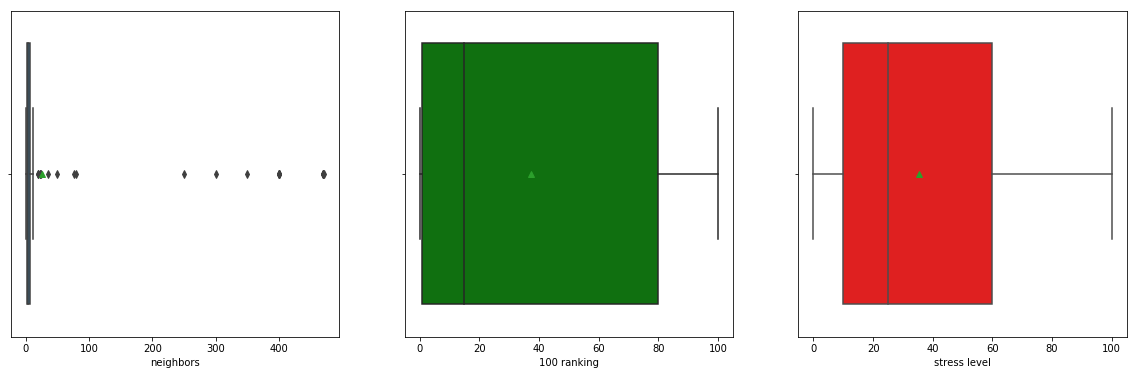

In [11]:
fig= plt.figure(figsize=(20,6))
plt.subplot(131)
ax = sns.boxplot(x = ODI['neighbors'], showmeans=True)
plt.subplot(132)
ax = sns.boxplot(x = ODI['100 ranking'], showmeans=True, color='G')
plt.subplot(133)
ax = sns.boxplot(x = ODI['stress level'], showmeans=True, color='r')

In [12]:
def RemoveOutliers(lower_bound, upper_bound, item):
    if item > lower_bound or item < upper_bound:
        item = float('NaN')
    return item

Q1 = ODI['neighbors'].quantile(0.25)
Q3 = ODI['neighbors'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1*1.5
upper_bound = Q3*1.5

ODI['neighbors'] = ODI['neighbors'].map(lambda x: InvalidValue(lower_bound, upper_bound, x))
ODI['neighbors'].describe()

count    119.000000
mean       5.462185
std        1.793538
min        3.000000
25%        4.000000
50%        5.000000
75%        7.000000
max        9.000000
Name: neighbors, dtype: float64

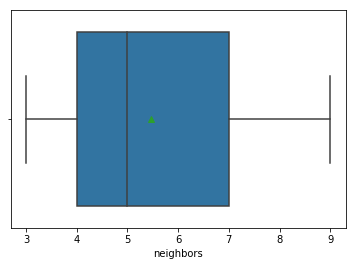

In [13]:
sns.boxplot(x = ODI['neighbors'], showmeans=True)

In [14]:
print(ODI.isnull().sum())

programme_AI                          0
programme_BA                          0
programme_Bio                         0
programme_CLS                         0
programme_CS                          0
programme_DBI                         0
programme_DS                          0
programme_E                           0
programme_Fin                         0
programme_Hea                         0
programme_IS                          0
programme_MA Language Technology      0
programme_MPAE                        0
programme_MS                          0
programme_Multiple programmes         0
programme_OR                          0
programme_Psychology                  0
programme_QRM                         0
programme_So                          0
programme_x                           0
gender                               13
machine learning                      3
information retrieval                 5
statistics                           10
databases                             3


In [15]:
ODI = ODI.drop(['neighbors'], axis=1)

Text(0.5,0,'stress level')

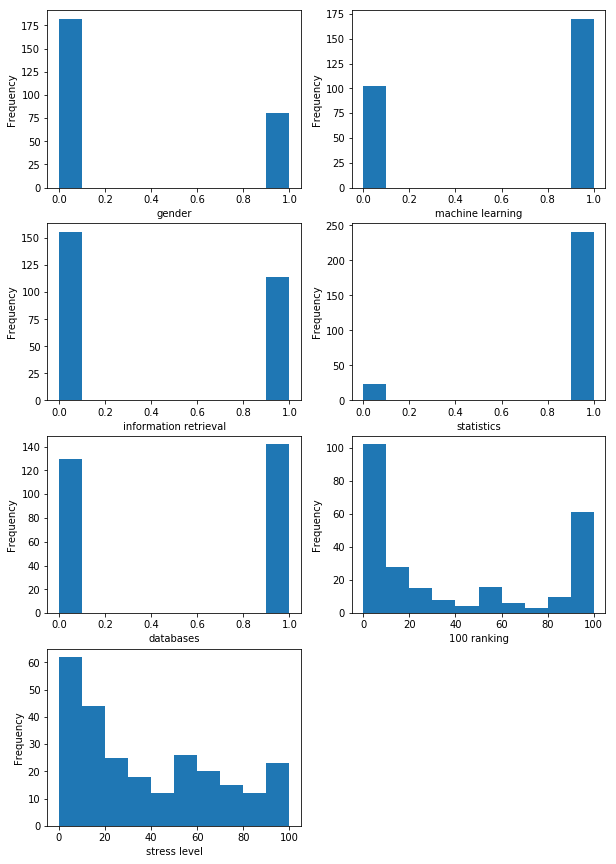

In [16]:
# missing value
fig= plt.figure(figsize=(10,15))
plt.subplot(421)
ODI['gender'].plot.hist(bins=10)
plt.xlabel('gender')
plt.subplot(422)
ODI['machine learning'].plot.hist(bins=10)
plt.xlabel('machine learning')
plt.subplot(423)
ODI['information retrieval'].plot.hist(bins=10)
plt.xlabel('information retrieval')
plt.subplot(424)
ODI['statistics'].plot.hist(bins=10)
plt.xlabel('statistics')
plt.subplot(425)
ODI['databases'].plot.hist(bins=10)
plt.xlabel('databases')
plt.subplot(426)
ODI['100 ranking'].plot.hist(bins=10)
plt.xlabel('100 ranking')
plt.subplot(427)
ODI['stress level'].plot.hist(bins=10)
plt.xlabel('stress level')

In [17]:
ODI['gender'] = ODI['gender'].fillna(0) 
ODI['machine learning'] = ODI['machine learning'].fillna(1)  
ODI['information retrieval'] = ODI['information retrieval'].fillna(0) 
ODI['statistics'] = ODI['statistics'].fillna(1) 
ODI['databases'] = ODI['databases'].fillna(1) 
ODI['100 ranking'] = ODI['100 ranking'].fillna(ODI['100 ranking'].median()) 
ODI['stress level'] = ODI['stress level'].fillna(ODI['stress level'].median()) 

In [18]:
ODI['100 ranking'] = ODI['100 ranking']/100.0
ODI['stress level'] = ODI['stress level']/100.0

In [19]:
ODI.head()

,programme_AI,programme_BA,programme_Bio,programme_CLS,programme_CS,programme_DBI,programme_DS,programme_E,programme_Fin,programme_Hea,...,programme_QRM,programme_So,programme_x,gender,machine learning,information retrieval,statistics,databases,100 ranking,stress level
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,1.0,1.0,1.0,1.0,1.00,0.25
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,1.0,1.0,0.00,0.01
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0.0,1.0,1.0,1.0,1.0,0.00,1.00
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0.0,1.0,1.0,1.0,1.0,0.42,0.00
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0.0,0.0,1.0,1.0,1.0,0.15,1.00


In [20]:
ODI.describe()

,programme_AI,programme_BA,programme_Bio,programme_CLS,programme_CS,programme_DBI,programme_DS,programme_E,programme_Fin,programme_Hea,...,programme_QRM,programme_So,programme_x,gender,machine learning,information retrieval,statistics,databases,100 ranking,stress level
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,...,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.00000,275.000000
mean,0.269091,0.149091,0.112727,0.112727,0.123636,0.029091,0.032727,0.061818,0.014545,0.007273,...,0.040000,0.003636,0.003636,0.290909,0.629091,0.414545,0.912727,0.527273,0.35640,0.346945
std,0.444296,0.356827,0.316836,0.316836,0.329766,0.168368,0.178246,0.241264,0.119942,0.085125,...,0.196316,0.060302,0.060302,0.455010,0.483929,0.493542,0.282749,0.500166,0.39355,0.308732
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.02000,0.100000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.15000,0.250000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.80000,0.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [21]:
#ODI.to_csv('/Users/xuluyao/Desktop/Data Mining/DM_assignment1/Q1/ODI_final.csv', index=False)

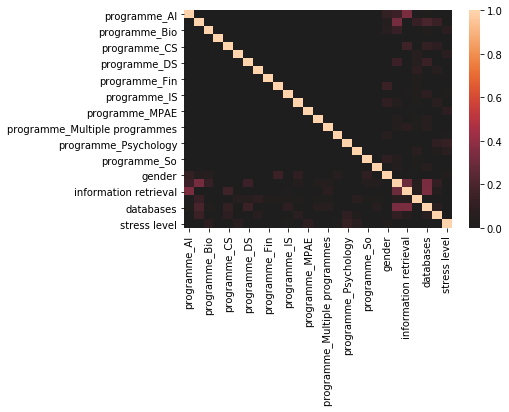

In [22]:
# Correlation
sns.heatmap(ODI.corr(),vmin=0, vmax=1, center=0)
plt.show()

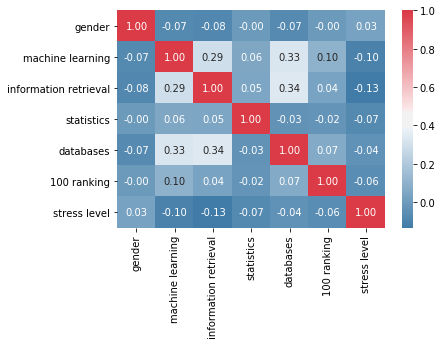

In [23]:
ODI.iloc[:,20:].corr()
colormap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
sns.heatmap(ODI.iloc[:,20:].corr(), cmap=colormap,annot=True, fmt=".2f")
plt.show()

Text(0.5,0,'number of students')

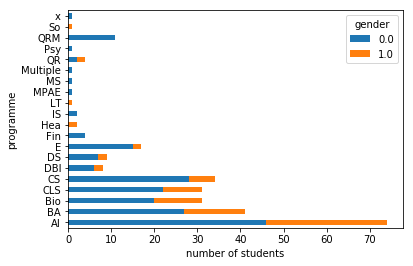

In [24]:
# Plotting1: programmes and gender
gender_pro = ODI[['programme_AI','programme_BA','programme_Bio','programme_CLS','programme_CS',
    'programme_DBI','programme_DS','programme_E','programme_Fin','programme_Hea',
    'programme_IS','programme_MA Language Technology','programme_MPAE','programme_MS','programme_Multiple programmes',
     'programme_OR','programme_Psychology','programme_QRM','programme_So','programme_x']].groupby(ODI['gender']).sum()
gender_pro = gender_pro.rename(columns = 
                 {'programme_AI':'AI','programme_BA':'BA','programme_Bio':'Bio','programme_CLS':'CLS',
                  'programme_CS':'CS','programme_DBI':'DBI','programme_DS':'DS','programme_E':'E',
                  'programme_Fin':'Fin','programme_Hea':'Hea','programme_IS':'IS',
                  'programme_MA Language Technology':'LT',
                  'programme_MPAE':'MPAE','programme_MS':'MS','programme_Multiple programmes':'Multiple',
                  'programme_OR':'QR','programme_Psychology':'Psy','programme_QRM':'QRM',
                  'programme_So':'So','programme_x':'x'})
pro_gender = gender_pro.transpose()
pro_gender.plot.barh(stacked=True)
plt.ylabel('programme')
plt.xlabel('number of students')

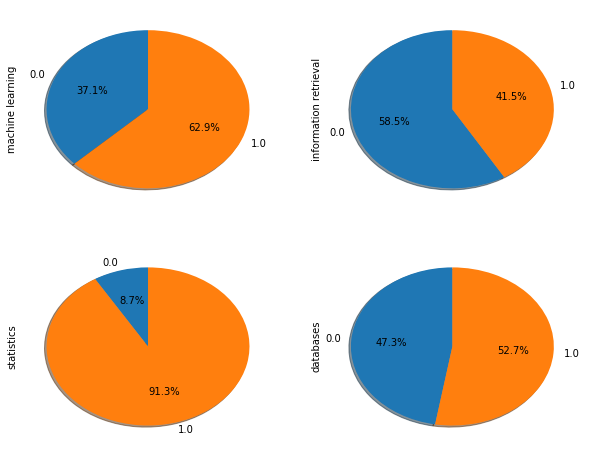

In [25]:
# Plotting2: courses
course_df = ODI.iloc[:,21:25].copy()
course_ratio_df = course_df.apply(lambda x: x.value_counts())
course_ratio = pd.DataFrame(course_ratio_df)
fig= plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
course_ratio['machine learning'].plot.pie(autopct='%1.1f%%',shadow=True,startangle=90)
plt.subplot(2,2,2)
course_ratio['information retrieval'].plot.pie(autopct='%1.1f%%',shadow=True,startangle=90)
plt.subplot(2,2,3)
course_ratio['statistics'].plot.pie(autopct='%1.1f%%',shadow=True,startangle=90)
plt.subplot(2,2,4)
course_ratio['databases'].plot.pie(autopct='%1.1f%%',shadow=True,startangle=90)

In [26]:
# Plotting3: self evaluation
self_evaluation = ODI[['100 ranking','stress level']].groupby(ODI['gender']).mean()
self_evaluation

,100 ranking,stress level
gender,,
0.0,0.356718,0.340667
1.0,0.355625,0.362250


In [27]:
def ClassStress(item):
    if item >= 0.5:
        item = 1
    else:
        item = 0
    return item
ODI['stress level'] = ODI['stress level'].apply(lambda x: ClassStress(x))

In [28]:
# Logistic Regression
import sklearn
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

LR = linear_model.LogisticRegression() 
features = ['programme_AI','programme_BA','programme_Bio','programme_CLS','programme_CS',
    'programme_DBI','programme_DS','programme_E','programme_Fin','programme_Hea',
    'programme_IS','programme_MA Language Technology','programme_MPAE','programme_MS','programme_Multiple programmes',
     'programme_OR','programme_Psychology','programme_QRM','programme_So','programme_x','gender','machine learning',
            'information retrieval','statistics','databases','100 ranking']
X = ODI[features]
Y = ODI['stress level']
LR.fit(X,Y)
scores_LR = cross_val_score(LR, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_LR)) #求平均的交叉检验的值

0.6365800865800866


In [29]:
# KNN
from sklearn import neighbors
KNN = neighbors.KNeighborsClassifier()
KNN.fit(X, Y)
scores_KNN = cross_val_score(KNN, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_KNN))

0.5932635882635883


In [30]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
gbc.fit(X, Y)
scores_gbc = cross_val_score(gbc, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_gbc))

0.6037109187109186


In [31]:
# Random forests
rfm = RandomForestClassifier(n_estimators=100)
rfm.fit(X, Y)
scores_rfm = cross_val_score(rfm, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_rfm))

0.6076118326118326


In [32]:
# SVM
svc = SVC()
svc.fit(X, Y)
scores_svc = cross_val_score(svc, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_svc))

0.650928330928331


In [33]:
# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X, Y)
scores_gnb = cross_val_score(gnb, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_gnb))

0.3564117364117364


In [34]:
# 
dt = DecisionTreeClassifier()
dt.fit(X, Y)
scores_dt = cross_val_score(dt, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_dt))

0.5709114959114959
